In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import copy
import os
import torch
from PIL import Image
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
%matplotlib inline

In [2]:
path = "/kaggle/input/aml-challenge-1/dataset"
import pandas as pd

labels_df = pd.read_csv(path+'/train.csv')  # Adjust filename
print(labels_df.head())

                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1


In [3]:
print(labels_df.shape)
labels_df[labels_df.duplicated(keep=False)]

(17500, 2)


,id,has_cactus


In [4]:
labels_df['has_cactus'].value_counts()

has_cactus
1    13136
0     4364
Name: count, dtype: int64

In [5]:
import torch
torch.manual_seed(0)

from torch.utils.data import Dataset
import os
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms

class pytorch_data(Dataset):
    
    def __init__(self, data_dir, transform, data_type="train"):
        # Get Image File Names
        cdm_data = os.path.join(data_dir, data_type)
        file_names = os.listdir(cdm_data)

        all_image_paths = [os.path.join(cdm_data, f) for f in file_names if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

        print(f"Found {len(all_image_paths)} images in directory.")
        print(f"Sample filenames: {all_image_paths[:1]}")

        # Get Labels
        labels_data = os.path.join("/kaggle/input/aml-challenge-1/dataset/", "train.csv")
        labels_df = pd.read_csv(labels_data)

        # Normalize index: remove extensions if present
        labels_df['id'] = labels_df['id'].apply(lambda x: os.path.splitext(str(x))[0])
        labels_df.set_index("id", inplace=True)

        print(f"Labels dataframe length: {len(labels_df)}")

        # Extract only valid images (that have a label)
        valid_filenames = []
        labels = []

        for f in all_image_paths:
            filename = os.path.basename(f)  # get only file name
            image_id = os.path.splitext(filename)[0]  # remove extension

            if image_id in labels_df.index:
                valid_filenames.append(f)
                labels.append(labels_df.loc[image_id].values[0])
            else:
                print(f"Warning: image '{filename}' has no matching label in train.csv")

        self.full_filenames = valid_filenames
        self.labels = labels
        self.transform = transform

        print(f"Valid image-label pairs: {len(self.full_filenames)}")
        print(f"First few labels: {self.labels[:5]}")
      
    def __len__(self):
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        if idx >= len(self.full_filenames):
            raise IndexError(f"Index {idx} out of bounds for dataset of length {len(self.full_filenames)}")

        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

In [6]:
# define transformation that converts a PIL image into PyTorch tensors
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((32,32))])

In [7]:
# Define an object of the custom dataset for the train folder.
data_dir = path+'/train/'
img_dataset = pytorch_data(data_dir, data_transformer, "train")

Found 17500 images in directory.
Sample filenames: ['/kaggle/input/aml-challenge-1/dataset/train/train/5d3a7d32516a92cc0dc8c52af515eaa4.jpg']
Labels dataframe length: 17500
Valid image-label pairs: 17500
First few labels: [1, 0, 1, 1, 1]


In [8]:
# define transformation that converts a PIL image into PyTorch tensors
data_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
])

In [9]:
# Test a sample
img, label = img_dataset[10]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 32, 32]) tensor(0.2667) tensor(0.8627)


**DATA AUGMENTATION CHE VA A RADDOPPIARE IL NUMERO DI SAMPLE DELLA CLASSE 0 AVENDO ALLA FINE CHE I SAMPLE DELLA CLASSE 0 SONO I 2/3 DEI SAMPLE DELLA CLASSE 1**

In [10]:
# Aumentiamo le immagini della classe 0
from torchvision.transforms import RandomRotation, ToTensor, Resize
from tqdm import tqdm

# Trasformazione per augmentare
augment_transform = transforms.Compose([
    RandomRotation(degrees=10),
    Resize((32, 32)),
    ToTensor()
])

# Trova solo immagini con etichetta 0
images_class0 = [i for i in range(len(img_dataset)) if img_dataset.labels[i] == 0]

# Duplichiamo queste immagini con trasformazione
augmented_images = []
augmented_labels = []

for idx in tqdm(images_class0):
    img_path = img_dataset.full_filenames[idx]
    img = Image.open(img_path)
    augmented_img = augment_transform(img)
    augmented_images.append(augmented_img)
    augmented_labels.append(0)

# Stack immagini originali
original_images = [img_dataset[i][0] for i in range(len(img_dataset))]
original_labels = [img_dataset[i][1] for i in range(len(img_dataset))]

# Combina immagini originali + augmentate
all_images = torch.stack(original_images + augmented_images)
all_labels = torch.tensor(original_labels + augmented_labels)

# Nuovo Dataset custom con dati augmentati
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Sostituisci img_dataset con quello nuovo
img_dataset = AugmentedDataset(all_images, all_labels)

100%|██████████| 4364/4364 [00:42<00:00, 101.93it/s]


***DIVISIONE NEI TRE SET TRAIN, VALIDATION, TEST DOPO AVER AUMENTATO I DATI DELLA CLASSE 0***

In [11]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# Estrai le etichette in modo sicuro
labels = img_dataset.labels  # NON usare img_dataset[i][1]

# Crea una lista di tutti gli indici
all_indices = list(range(len(img_dataset)))

# Split stratificato: Train (70%) e Temp (30%)
train_idx, temp_idx = train_test_split(
    all_indices, test_size=0.3, stratify=labels, random_state=42
)

# Estrai le label corrispondenti agli indici temporanei per secondo split
temp_labels = [labels[i] for i in temp_idx]

# Split stratificato: Validation (15%) e Test (15%) da temp
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=temp_labels, random_state=42
)

# Crea i subset PyTorch
train_ts = Subset(img_dataset, train_idx)
val_ts = Subset(img_dataset, val_idx)
test_ts = Subset(img_dataset, test_idx)

# Visualizzazione
print("train dataset size:", len(train_ts))
print("validation dataset size:", len(val_ts))
print("test dataset size:", len(test_ts))

train dataset size: 15304
validation dataset size: 3280
test dataset size: 3280


In [12]:
from torch.utils.data import DataLoader

# Training DataLoader
train_dl = DataLoader(train_ts,
                      batch_size=64, 
                      shuffle=True)

# Validation DataLoader
val_dl = DataLoader(val_ts,
                    batch_size=64,
                    shuffle=False)

In [13]:
import torch
torch.manual_seed(0)
from torch.utils.data import DataLoader

from torch.utils.data import Dataset
import os
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
class UnlabeledDataset(Dataset):
    def __init__(self, data_dir, transform):
        self.transform = transform
        file_names = os.listdir(data_dir)
        self.image_paths = [os.path.join(data_dir, f) for f in file_names
                            if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        print(f"Found {len(self.image_paths)} unlabeled images in 'test'.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = self.transform(image)
        return image

# Trasformazione coerente
data_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
])
print(path)
# Path alla cartella test (modifica se necessario)
unlabeled_data_dir = path + '/test/test'
unlabeled_dataset = UnlabeledDataset(unlabeled_data_dir, data_transformer)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=False)


/kaggle/input/aml-challenge-1/dataset
Found 4000 unlabeled images in 'test'.


In [14]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

import torch.nn as nn
import torch.nn.functional as F

# Neural Network
class Network(nn.Module):
    
    # Network Initialisation
    def __init__(self, params):
        
        super(Network, self).__init__()
    
        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        # Convolution Layers
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3, padding=1)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,padding=1)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3, padding=1)
        h,w=findConv2dOutShape(h,w,self.conv3)
        
        # compute the flatten size
        self.num_flatten=h*w*4*init_f   #4*8 -> 32
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    

    def forward(self,X):
        # Convolution & Pool Layers
        X = F.relu(self.conv1(X));
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)

        b = X.shape[0]
        X = X.view(b,-1) #torch appiattisce su tutti i canali, tranne il primo che corrisponde alla batch size
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, DataLoader

# Best parameters (già forniti)
best_params = {
    'lr': 0.001,
    'dropout_rate': 0.25,
    'initial_filters': 32,
    'num_fc1': 64
}
# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Costruzione del modello finale
final_params = {
    "shape_in": (3, 32, 32),
    "initial_filters": best_params["initial_filters"],
    "num_fc1": best_params["num_fc1"],
    "dropout_rate": best_params["dropout_rate"],
    "num_classes": 2
}

final_model_CNN = Network(final_params).to(device)

# Unione train + validation
full_train_set = ConcatDataset([train_ts, val_ts])
full_train_loader = DataLoader(full_train_set, batch_size=64, shuffle=True)

# Ottimizzatore e funzione di perdita
optimizer = torch.optim.Adam(final_model_CNN.parameters(), lr=best_params["lr"])
criterion = nn.NLLLoss()

# Training
final_model_CNN.train()
for epoch in range(10):
    running_loss = 0.0
    for X_batch, y_batch in full_train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = final_model_CNN(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {running_loss:.4f}")

# Validazione finale sul test set
test_loader = DataLoader(test_ts, batch_size=64, shuffle=False)
final_model_CNN.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        output = final_model_CNN(X_batch)
        preds = output.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

from sklearn.metrics import accuracy_score, classification_report
accuracy_CNN=accuracy_score(y_true, y_pred)
print("🎯 Test Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))


Epoch 1 - Loss: 63.9040
Epoch 2 - Loss: 30.9451
Epoch 3 - Loss: 21.3514
Epoch 4 - Loss: 13.9194
Epoch 5 - Loss: 10.8894
Epoch 6 - Loss: 9.5821
Epoch 7 - Loss: 8.6208
Epoch 8 - Loss: 7.2201
Epoch 9 - Loss: 6.1977
Epoch 10 - Loss: 5.2063
🎯 Test Accuracy: 0.9929878048780488
              precision    recall  f1-score   support

           0     0.9879    0.9947    0.9912      1309
           1     0.9964    0.9919    0.9942      1971

    accuracy                         0.9930      3280
   macro avg     0.9921    0.9933    0.9927      3280
weighted avg     0.9930    0.9930    0.9930      3280



In [16]:
def predict_unlabeled(model, loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for X_batch in loader:
            X_batch = X_batch.to(device)
            output = model(X_batch)
            preds = output.argmax(dim=1).cpu().numpy()
            predictions.extend(preds)

    return predictions


In [17]:
def initialize_weights_and_bias(dimension):
    w = np.full((dimension,1),0.01)
    b = 0.0
    return w, b

def sigmoid(z):
    y_head = 1/(1+np.exp(-z))
    return y_head

def forward_backward_propagation(w,b,x_train,y_train):
    # forward propagation
    z = np.dot(w.T,x_train) + b
    y_head = sigmoid(z)
    loss = -y_train*np.log(y_head)-(1-y_train)*np.log(1-y_head)
    cost = (np.sum(loss))/x_train.shape[1]
    # backward propagation
    derivative_weight = (np.dot(x_train,((y_head-y_train).T)))/x_train.shape[1]
    derivative_bias = np.sum(y_head-y_train)/x_train.shape[1]
    gradients = {"derivative_weight": derivative_weight,"derivative_bias": derivative_bias}
    return cost,gradients

def update(w, b, x_train, y_train, learning_rate,number_of_iterarion):
    cost_list = []
    cost_list2 = []
    index = []
    
    for i in range(number_of_iterarion):
        
        cost,gradients = forward_backward_propagation(w,b,x_train,y_train)
        cost_list.append(cost)
        
        w = w - learning_rate * gradients["derivative_weight"]
        b = b - learning_rate * gradients["derivative_bias"]
        if i % 100 == 0:
            cost_list2.append(cost)
            index.append(i)
            print ("Cost after iteration %i: %f" %(i, cost))
    
    parameters = {"weight": w,"bias": b}
    plt.plot(index,cost_list2)
    plt.xticks(index,rotation='vertical')
    plt.xlabel("Number of Iterarion")
    plt.ylabel("Cost")
    plt.show()
    return parameters, gradients, cost_list

def predict(w,b,x_test):
    
    z = sigmoid(np.dot(w.T,x_test)+b)
    Y_prediction = np.zeros((1,x_test.shape[1]))

    for i in range(z.shape[1]):
        if z[0,i]<= 0.5:
            Y_prediction[0,i] = 0
        else:
            Y_prediction[0,i] = 1

    return Y_prediction

def logistic_regression(x_train, y_train, x_test, y_test, learning_rate ,  num_iterations):

    dimension =  x_train.shape[0]
    w,b = initialize_weights_and_bias(dimension)

    parameters, gradients, cost_list = update(w, b, x_train, y_train, learning_rate,num_iterations)
    
    y_prediction_test = predict(parameters["weight"],parameters["bias"],x_test)
    y_prediction_train = predict(parameters["weight"],parameters["bias"],x_train)
    
    print("Test Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2)))
    print("Train Accuracy: {} %".format(round(100 - np.mean(np.abs(y_prediction_train - y_train)) * 100,2)))
    acc= (round(100 - np.mean(np.abs(y_prediction_test - y_test)) * 100,2))
    return acc

Cost after iteration 0: 5.936325
Cost after iteration 100: 0.540683
Cost after iteration 200: 0.479720
Cost after iteration 300: 0.444329
Cost after iteration 400: 0.420768
Cost after iteration 500: 0.403783
Cost after iteration 600: 0.390880
Cost after iteration 700: 0.380702
Cost after iteration 800: 0.372433
Cost after iteration 900: 0.365557
Cost after iteration 1000: 0.359725
Cost after iteration 1100: 0.354698
Cost after iteration 1200: 0.350303
Cost after iteration 1300: 0.346412


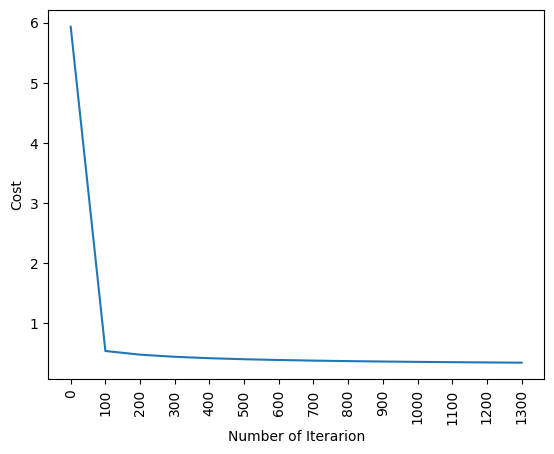

Test Accuracy: 83.87 %
Train Accuracy: 84.27 %


In [18]:
import numpy as np

def subset_to_numpy(subset):
    images = []
    labels = []
    for img, label in subset:
        images.append(img.numpy().flatten())  # flatten 3D tensor to 1D vector
        labels.append(label)
    X = np.array(images).T  # shape: (features, samples)
    Y = np.array(labels).reshape(1, -1)  # shape: (1, samples)
    return X, Y

# Convert datasets to NumPy
x_train, y_train = subset_to_numpy(train_ts)
x_test, y_test = subset_to_numpy(test_ts)

# Call your logistic regression function
accuracy_log=logistic_regression(x_train, y_train, x_test, y_test, learning_rate=0.01, num_iterations=1400)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Reuse conversion function
def dataset_to_numpy(dataset):
    X = []
    y = []
    for img, label in dataset:
        X.append(img.view(-1).numpy())  # Flatten image
        y.append(label)
    return np.array(X), np.array(y)

# Prepare data
X_train, y_train = dataset_to_numpy(train_ts)
X_val, y_val = dataset_to_numpy(val_ts)
X_test, y_test = dataset_to_numpy(test_ts)
# Combine training and validation sets
X_train_final = np.concatenate((X_train, X_val))
y_train_final = np.concatenate((y_train, y_val))

# Retrain with best parameters
final_model_log = LogisticRegression(
    C=10,
    penalty='l2',
    solver='lbfgs',
    max_iter=1500
)
final_model_log.fit(X_train_final, y_train_final)

# Predict on test set
y_pred_test = final_model_log.predict(X_test)

# Evaluate
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"✅ Final Test Accuracy: {test_accuracy * 100:.2f}%\n")
accuracy_log=test_accuracy
# Optional: Detailed classification report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred_test))

✅ Final Test Accuracy: 91.62%

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1309
           1       0.94      0.92      0.93      1971

    accuracy                           0.92      3280
   macro avg       0.91      0.92      0.91      3280
weighted avg       0.92      0.92      0.92      3280



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=64, shuffle=False)
import numpy as np

def predict_unlabeled_sklearn(model, loader):
    model_preds = []

    for X_batch in loader:
        # Se il loader restituisce tuple, prendi solo le immagini
        if isinstance(X_batch, (list, tuple)):
            X_batch = X_batch[0]

        # Converti da Tensor a NumPy
        X_np = X_batch.numpy()  # shape: (B, 3, 32, 32)

        # Flatten per Logistic Regression: (B, 3*32*32)
        X_np = X_np.reshape(X_np.shape[0], -1)

        preds = model.predict(X_np)
        model_preds.extend(preds)

    return model_preds



In [21]:
from sklearn.metrics import classification_report, accuracy_score
from torchvision.models import resnet18
import torch, torch.nn as nn
from torch.utils.data import Subset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1️⃣  Loader per train + val (indici train_idx) e per test (già definito)
train_val_dataset = Subset(img_dataset, train_idx)
train_val_loader  = DataLoader(train_val_dataset, batch_size=64, shuffle=True)

# se non hai già test_loader:
test_loader = DataLoader(test_ts, batch_size=64, shuffle=False)

# 2️⃣  ResNet18 senza pesi preaddestrati – iperparametri: lr=0.001, opt=Adam
final_model_Res = resnet18(weights=None)
num_classes = len({lbl for _, lbl in train_val_dataset})
final_model_Res.fc = nn.Linear(final_model_Res.fc.in_features, num_classes)
final_model_Res.to(device)

criterion  = nn.CrossEntropyLoss()
optimizer  = torch.optim.SGD(final_model_Res.parameters(), lr=0.001, momentum=0.9)
num_epochs = 15

# 3️⃣  Training su train + val con print di progresso
for epoch in range(num_epochs):
    final_model_Res.train()
    running_loss = 0.0
    total_batches = len(train_val_loader)

    print(f"\n🟢 Epoch {epoch+1}/{num_epochs} - Training...")

    for batch_idx, (imgs, labels) in enumerate(train_val_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model_Res(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0 or (batch_idx + 1) == total_batches:
            print(f"  🔁 Batch {batch_idx + 1}/{total_batches} - Loss: {loss.item():.4f}")

    avg_loss = running_loss / total_batches
    print(f"✅ Epoch {epoch+1} completed - Avg Loss: {avg_loss:.4f}")

# 4️⃣  Valutazione sul test set
y_true, y_pred = [], []
final_model_Res.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        _, preds = torch.max(final_model_Res(imgs), 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("🎯 Test Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, digits=4))
accuracy_Res=accuracy_score(y_true, y_pred)


🟢 Epoch 1/15 - Training...
  🔁 Batch 10/240 - Loss: 3.3768
  🔁 Batch 20/240 - Loss: 0.4896
  🔁 Batch 30/240 - Loss: 0.1164
  🔁 Batch 40/240 - Loss: 0.1034
  🔁 Batch 50/240 - Loss: 0.1496
  🔁 Batch 60/240 - Loss: 0.1525
  🔁 Batch 70/240 - Loss: 0.3921
  🔁 Batch 80/240 - Loss: 0.3161
  🔁 Batch 90/240 - Loss: 0.1472
  🔁 Batch 100/240 - Loss: 0.0486
  🔁 Batch 110/240 - Loss: 0.1719
  🔁 Batch 120/240 - Loss: 0.1585
  🔁 Batch 130/240 - Loss: 0.0786
  🔁 Batch 140/240 - Loss: 0.1114
  🔁 Batch 150/240 - Loss: 0.1885
  🔁 Batch 160/240 - Loss: 0.0484
  🔁 Batch 170/240 - Loss: 0.0802
  🔁 Batch 180/240 - Loss: 0.1761
  🔁 Batch 190/240 - Loss: 0.0540
  🔁 Batch 200/240 - Loss: 0.0854
  🔁 Batch 210/240 - Loss: 0.2683
  🔁 Batch 220/240 - Loss: 0.1350
  🔁 Batch 230/240 - Loss: 0.1239
  🔁 Batch 240/240 - Loss: 0.1027
✅ Epoch 1 completed - Avg Loss: 0.4864

🟢 Epoch 2/15 - Training...
  🔁 Batch 10/240 - Loss: 0.1256
  🔁 Batch 20/240 - Loss: 0.0157
  🔁 Batch 30/240 - Loss: 0.2197
  🔁 Batch 40/240 - Loss: 0

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import torch

# Funzione per convertire un dataset PyTorch in NumPy
def dataset_to_numpy(dataset):
    X = []
    y = []
    for img, label in dataset:
        X.append(img.view(-1).numpy())  # Flatten image (3x32x32 → 3072)
        y.append(label)
    return np.array(X), np.array(y)

# Converti i dataset
X_train, y_train = dataset_to_numpy(train_ts)
X_val, y_val     = dataset_to_numpy(val_ts)
X_test, y_test   = dataset_to_numpy(test_ts)

# Normalizza
X_train = X_train / 255.0
X_val   = X_val / 255.0
X_test  = X_test / 255.0

# Combina train + val per addestrare il modello finale
X_combined = np.concatenate((X_train, X_val))
y_combined = np.concatenate((y_train, y_val))

# 🔧 Crea e addestra il modello con i best params
final_model_SVM = SVC(C=10, kernel='rbf', gamma='scale')
final_model_SVM.fit(X_combined, y_combined)

# 🔍 Valutazione sul test set
test_preds = final_model_SVM.predict(X_test)
accuracy_SVM = accuracy_score(y_test, test_preds)

print(f"\n🎯 Test Accuracy: {accuracy_SVM * 100:.2f}%")
print(classification_report(y_test, test_preds, digits=4))



🎯 Test Accuracy: 95.88%
              precision    recall  f1-score   support

           0     0.9407    0.9572    0.9489      1309
           1     0.9713    0.9599    0.9656      1971

    accuracy                         0.9588      3280
   macro avg     0.9560    0.9586    0.9572      3280
weighted avg     0.9591    0.9588    0.9589      3280



In [30]:
logreg_preds = predict_unlabeled_sklearn(final_model_log, unlabeled_loader)
svm_predictions = predict_unlabeled_sklearn(final_model_SVM, unlabeled_loader)
cnn_predictions = predict_unlabeled(final_model_CNN, unlabeled_loader)
res_predictions= predict_unlabeled(final_model_Res, unlabeled_loader)


In [24]:
# Calcola i pesi (proporzionali all'accuracy)
total = accuracy_log + accuracy_SVM + accuracy_CNN + accuracy_Res
weights = [
    accuracy_log / total,
    accuracy_SVM    / total,
    accuracy_CNN    / total,
    accuracy_Res / total
]


In [25]:
# Calcola il voto pesato per ogni immagine
final_predictions = []

for lr, svm, cnn, res in zip(logreg_preds, svm_predictions, cnn_predictions, res_predictions):
    weighted_vote = (
        weights[0] * lr +
        weights[1] * svm +
        weights[2] * cnn +
        weights[3] * res
    )
    final_label = 1 if weighted_vote >= 0.5 else 0
    final_predictions.append(final_label)


In [29]:
# Estrai i nomi dei file dal dataset
image_ids = [os.path.splitext(os.path.basename(p))[0] for p in unlabeled_dataset.image_paths]

submission_df = pd.DataFrame({
    'id': image_ids,  # già ottenuti prima da unlabeled_dataset
    'label': final_predictions
})

submission_df.to_csv('ensemble_predictions.csv', index=False)
print("✅ File 'ensemble_predictions.csv' salvato con successo.")


✅ File 'ensemble_predictions.csv' salvato con successo.
